In [1]:
# Check for GPU
!nvidia-smi

Tue May  7 17:09:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42
device

'cuda'

## 1. Making a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset has 1000 samples and a `random_state=42`.
  * Turning the data into PyTorch tensors.
  * Splitting the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [3]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

NUM_SAMPLES = 1000

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.07,
                  random_state=RANDOM_SEED)

In [4]:
# Turn data into a DataFrame
import pandas as pd

data_df = pd.DataFrame({'X1': X[:, 0],
                     'X2': X[:, 1],
                     'y': y})

data_df.head()

,X1,X2,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


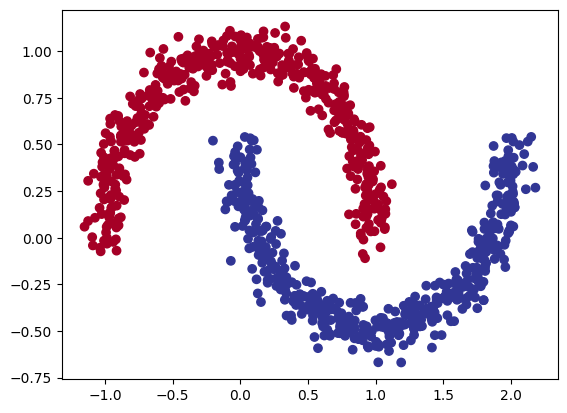

In [5]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [6]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data

In [7]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
      super().__init__()

      self.layer_1 = nn.Linear(in_features=in_features,
                               out_features=hidden_units)
      self.layer_2 = nn.Linear(in_features=hidden_units,
                               out_features=hidden_units)
      self.layer_3 = nn.Linear(in_features=hidden_units,
                               out_features=out_features)
      self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Instantiate the model
model_1 = MoonModel(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_1

MoonModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [8]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.3444,  0.5208],
                      [-0.3464, -0.1706],
                      [-0.5002,  0.1297],
                      [-0.6169, -0.4226],
                      [ 0.6500,  0.6234],
                      [-0.1192, -0.1463],
                      [ 0.3373, -0.6843],
                      [-0.1574, -0.6292],
                      [ 0.5170,  0.0128],
                      [ 0.0869, -0.5662]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.3055,  0.0434,  0.0761,  0.3669, -0.1868, -0.0648,  0.4379,  0.1034,
                      -0.4913, -0.3565], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2497,  0.1062,  0.2515, -0.3140, -0.0094,  0.1141, -0.1584,  0.2287,
                        0.1760, -0.0415],
                      [ 0.2949, -0.0261, -0.1437, -0.2858, -0.2560,  0.1746,  0.1541, -0.1490,
                        0.0873, -0.0329],
                      [ 0.1644,  0.258

## 3. Setup a binary classification compatible loss function and optimizer

In [9]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * Measure model accuray, creating accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy

In [10]:
# logits (raw outputs of model)
print("Logits:")
print(model_1(X_train.to(device)[:10]).squeeze())
# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_1(X_train.to(device)[:10]).squeeze()))
# Prediction labels
print("Pred labels:")
print(torch.round(torch.sigmoid(model_1(X_train.to(device)[:10]).squeeze())))

Logits:
tensor([ 0.0359,  0.0931,  0.0855,  0.0823, -0.0145,  0.0779, -0.0255,  0.0019,
         0.1034,  0.0892], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5090, 0.5233, 0.5214, 0.5206, 0.4964, 0.5195, 0.4936, 0.5005, 0.5258,
        0.5223], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [11]:
# Calculate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task='multiclass', num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.2 MB/s eta 0:00:00


MulticlassAccuracy()

In [12]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass (logits output)
  y_logits = model_1(X_train).squeeze()
  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()
  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_1(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out each 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.72 Acc: 0.18 | Test loss: 0.71 Test acc: 0.15
Epoch: 100 | Loss: 0.54 Acc: 0.84 | Test loss: 0.55 Test acc: 0.81
Epoch: 200 | Loss: 0.30 Acc: 0.89 | Test loss: 0.31 Test acc: 0.89
Epoch: 300 | Loss: 0.23 Acc: 0.91 | Test loss: 0.22 Test acc: 0.90
Epoch: 400 | Loss: 0.18 Acc: 0.92 | Test loss: 0.18 Test acc: 0.91
Epoch: 500 | Loss: 0.14 Acc: 0.94 | Test loss: 0.14 Test acc: 0.94
Epoch: 600 | Loss: 0.10 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 700 | Loss: 0.06 Acc: 0.99 | Test loss: 0.06 Test acc: 0.99
Epoch: 800 | Loss: 0.04 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 900 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00


## 5. Making predictions with trained model and plot them using the `plot_decision_boundary()` function

In [13]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

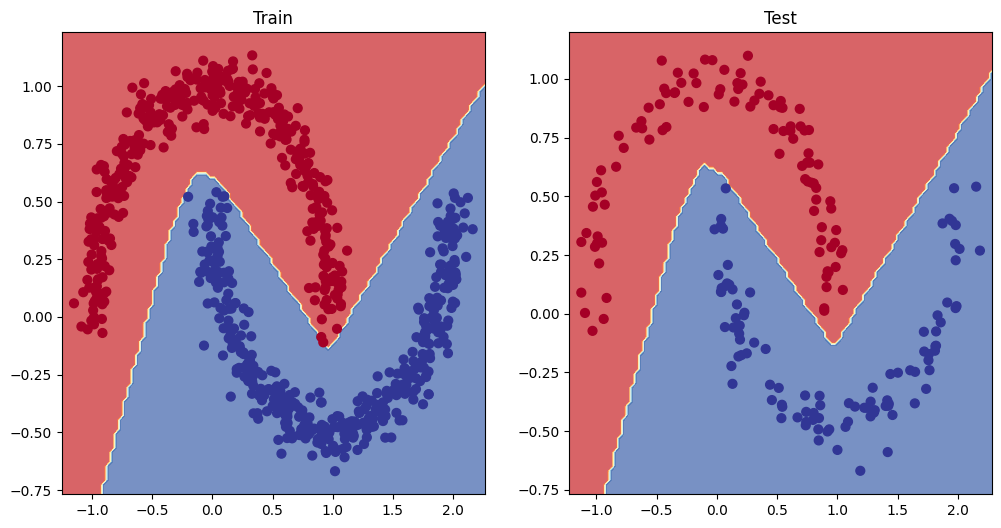

In [14]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. Replicating the Tanh (hyperbolic tangent) activation function in pure PyTorch
  * Reference to [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula

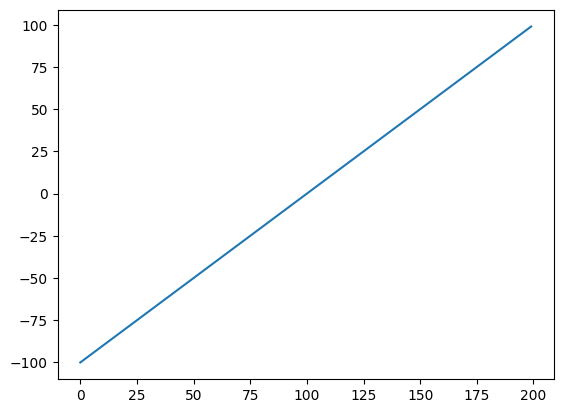

In [15]:
# Create a straight line tensor
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

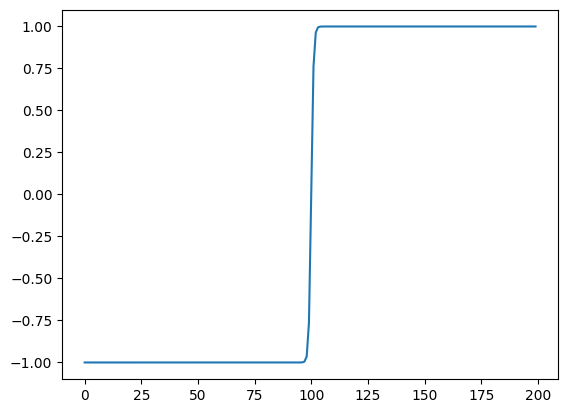

In [16]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(tensor_A))

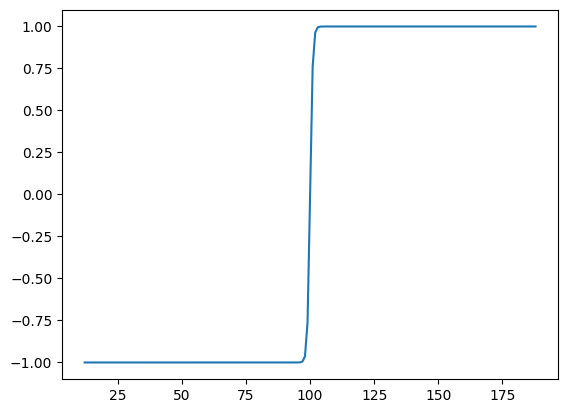

In [17]:
# Replicating torch.tanh() and plot it
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))